# PPOL 564 Data Science I

# Problem Set 4

## Anandi Gupta


In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

## Data 

In [2]:
dat = pd.read_csv("/Users/anandigupta/Desktop/Data Science/Problem Sets/Problem Set 4/Data/credit_data.csv")

In [3]:
dat.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,good,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,good,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,bad,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,good,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,good,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910


In [4]:
dat.shape

(4454, 14)

In [5]:
dat.dtypes

Status        object
Seniority      int64
Home          object
Time           int64
Age            int64
Marital       object
Records       object
Job           object
Expenses       int64
Income       float64
Assets       float64
Debt         float64
Amount         int64
Price          int64
dtype: object

In [6]:
for col in ['Home', 'Marital', 'Records', 'Job']:
    dat[col] = dat[col].astype('category')

### Question 1

In [7]:
#Split data into train and test

y = dat[['Status']]
X = dat.drop(columns=['Status'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [8]:
print(train_X.shape[0]/dat.shape[0])
print(test_X.shape[0]/dat.shape[0])

0.7498877413560844
0.25011225864391556


### Question 2

<AxesSubplot:>

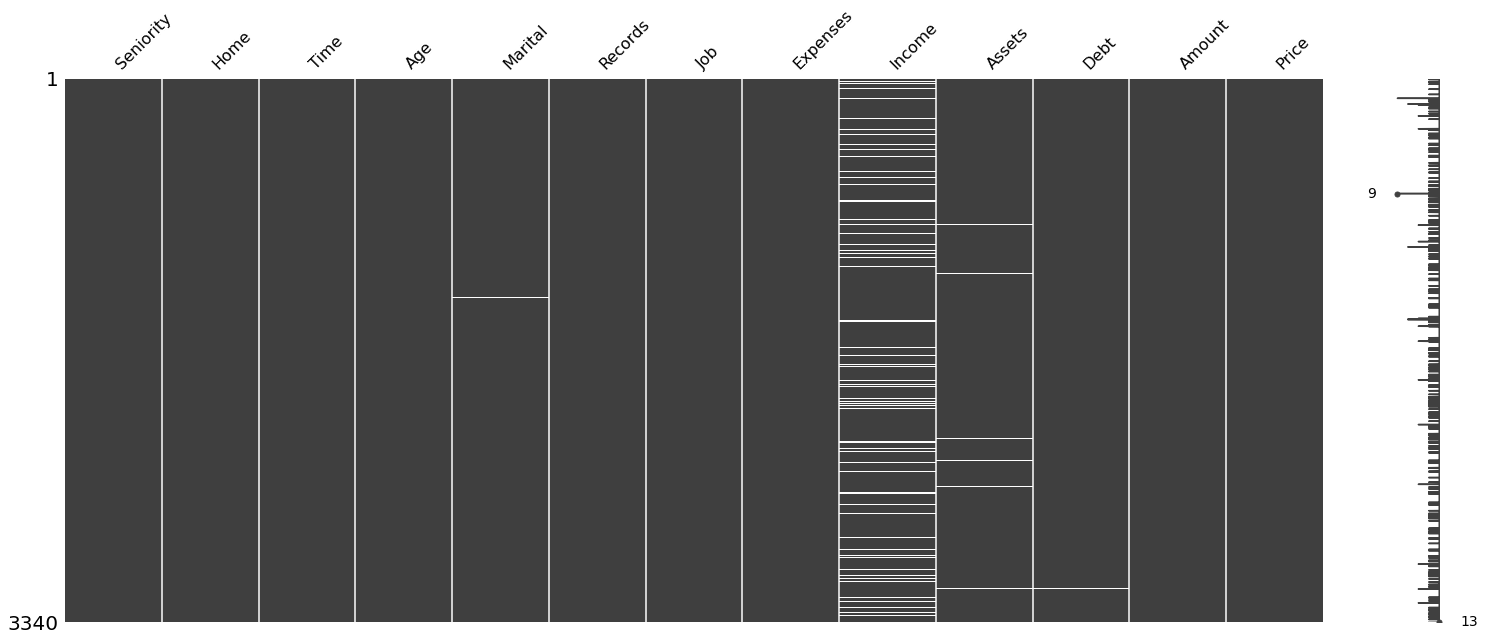

In [9]:
#Explore the training data

#Check for missingness

miss.matrix(train_X) # Income is missing for several observations

In [10]:
train_X.isna().sum()
#Income is missing for several observations and needs to be filled in 
#Cannot use 0 income (misleading)
#Use median income (later)

Seniority      0
Home           2
Time           0
Age            0
Marital        1
Records        0
Job            0
Expenses       0
Income       293
Assets        37
Debt          13
Amount         0
Price          0
dtype: int64

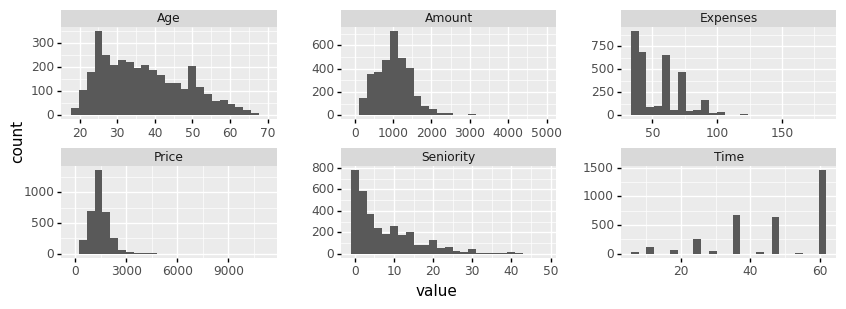

<ggplot: (8772265073502)>

In [11]:
#Explore the training data

# Plot the continuous Variables 
d = train_X.select_dtypes(include="int").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.3, 'hspace': 0.5})
)

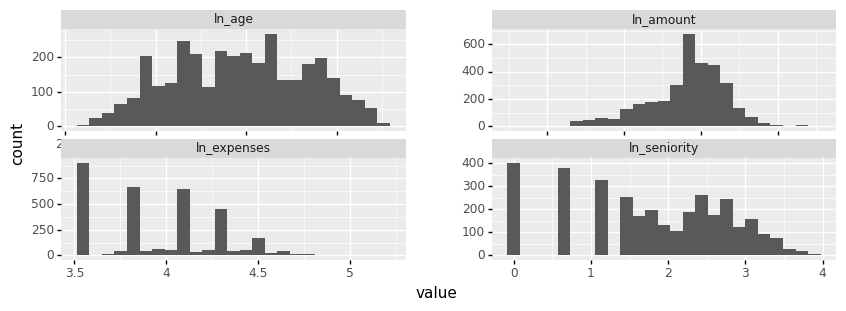

<ggplot: (8772294906778)>

In [12]:
#age, amount, expenses and seniority have right skew - consider log transforming

d = train_X.copy()
d['ln_age'] =  np.log(d['Age'])
d['ln_amount'] =  np.log(d['Amount'])
d['ln_expenses'] =  np.log(d['Expenses'])
d['ln_seniority'] =  np.log(d['Seniority'] + 1)

# Plot the continuous Variables 
d = d.filter(['ln_age', 'ln_amount', 'ln_expenses', 'ln_seniority']).melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

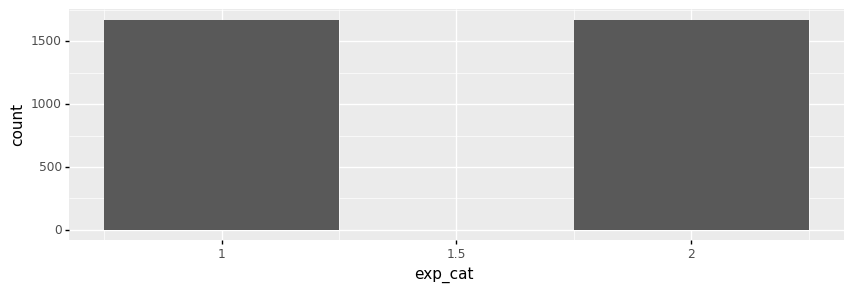

<ggplot: (8772245256479)>

In [13]:
#still seeing skew in expenses and senioriity
d = train_X.copy()
# Break expensense up into categories: below the median, above the median.
median_exp = d.Expenses.median()
d['exp_cat'] =  np.where(d['Expenses'] <= median_exp,1,2)
(
    ggplot(d,aes(x="exp_cat")) +
    geom_histogram(bins=3) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

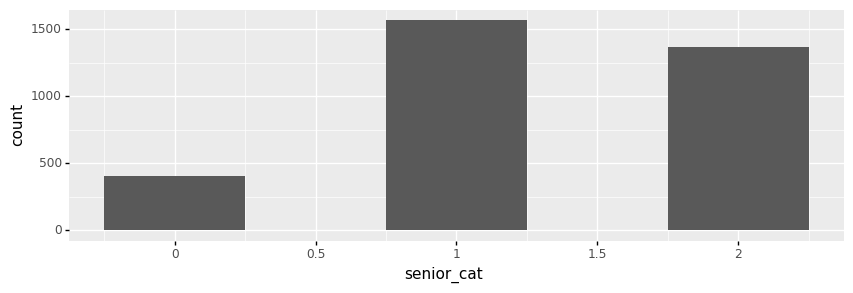

<ggplot: (8772265161346)>

In [14]:
# Break seniority up into categories: none, below the median, above the median.
median_seniority = d.loc[d['Seniority'] > 0,'Seniority'].median()
d['senior_cat'] =  np.where(d['Seniority']==0,0,np.where(d['Seniority'] <= median_seniority,1,2))
(
    ggplot(d,aes(x="senior_cat")) +
    geom_histogram(bins=5) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

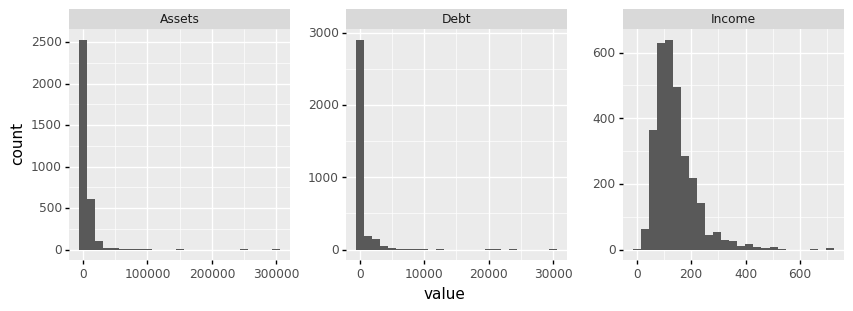

<ggplot: (8772265073942)>

In [15]:
# Plot the float Variables 
d = train_X.select_dtypes(include="float").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

All are right skewed. Consider log transforming.

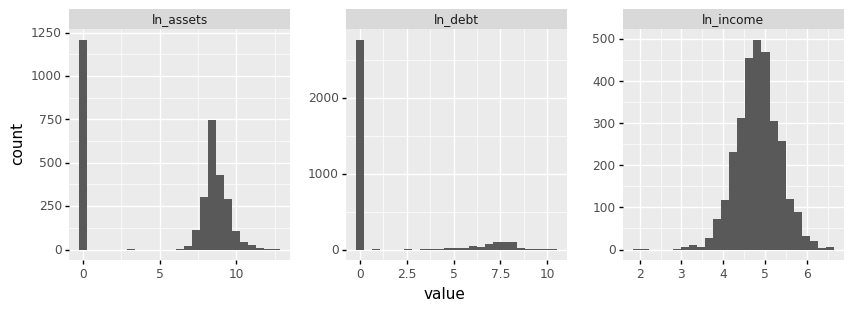

<ggplot: (8772245212925)>

In [16]:
d = train_X.copy()
d['ln_assets'] =  np.log(d['Assets'] + 1)
d['ln_debt'] =  np.log(d['Debt'] + 1)
d['ln_income'] =  np.log(d['Income'] + 1)

# Plot the continuous Variables 
d = d.filter(['ln_assets', 'ln_debt', 'ln_income']).melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

Still see skew in assets and debt - convert to categorical

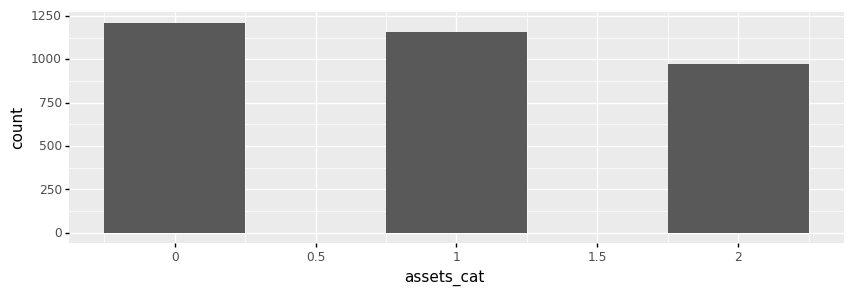

<ggplot: (8772245177712)>

In [17]:
# Break assets up into categories: none, below the median, above the median.
d = train_X.copy()

median_assets = d.loc[d['Assets'] > 0,'Assets'].median()
d['assets_cat'] =  np.where(d['Assets']==0,0,np.where(d['Assets'] <= median_assets,1,2))
(
    ggplot(d,aes(x="assets_cat")) +
    geom_histogram(bins=5) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

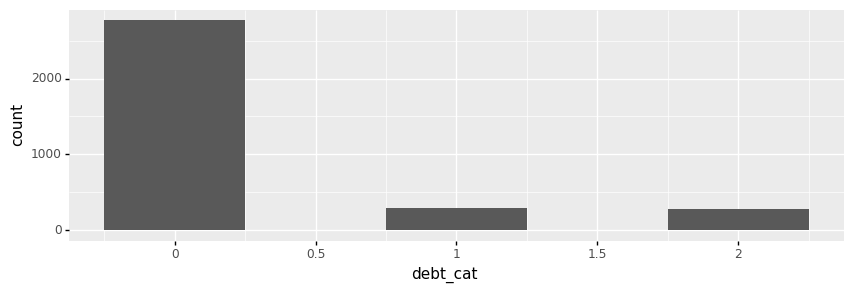

<ggplot: (8772279582449)>

In [18]:
# Break debt up into categories: none, below the median, above the median.
d = train_X.copy()

median_debt = d.loc[d['Debt'] > 0,'Debt'].median()
d['debt_cat'] =  np.where(d['Debt']==0,0,np.where(d['Debt'] <= median_debt,1,2))
(
    ggplot(d,aes(x="debt_cat")) +
    geom_histogram(bins=5) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

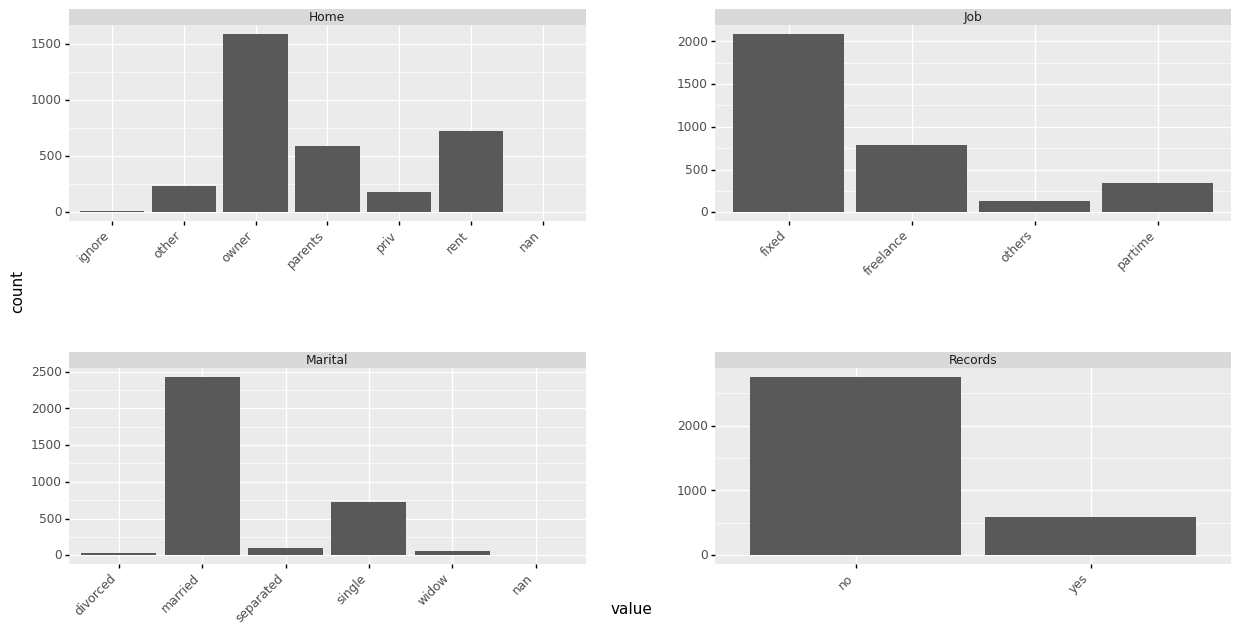

<ggplot: (8772265168412)>

In [19]:
#Plot the categorical variables

d = train_X.select_dtypes(include="category").melt()
(
    ggplot(d,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

No intrinsic ordering

## Question 3

## Pre-Processing Pipeline

In [20]:
#update status to numeric
dat.loc[dat.Status == 'good', 'Status'] = 1
dat.loc[dat.Status == 'bad', 'Status'] = 0
dat['Status'] = dat['Status'].astype('int')

#update records to numeric
dat['Records'] = dat['Records'].astype('object')
dat.loc[dat.Records == 'yes', 'Records'] = 1
dat.loc[dat.Records == 'no', 'Records'] = 0

#collapse job category - fixed, freelance, and other
dat['fixed'] = 1 * (dat['Job'] == 'fixed')
dat['freelance'] = 1 * (dat['Job'] == 'freelance')
dat = dat.drop('Job', axis = 1)

#collapse married category - married vs other
dat['Married'] = 0
dat.loc[dat['Marital']=='married', 'Married'] = 1
dat = dat.drop('Marital', axis = 1)

#collapse Homeowner category - owner, renter, other
dat['owner'] = 1 * (dat['Home'] == 'owner')
dat['rent'] = 1 * (dat['Home'] == 'rent')
dat = dat.drop(columns=["Home"])


#log skewed variables (add 1 as log of 0 is negative infinity)
dat['Age'] =  np.log(dat['Age']+ 1)
dat['Amount'] =  np.log(dat['Amount']+ 1)
dat['Income'] =  np.log(dat['Income']+ 1)


## Re-split using changed data

In [21]:
train, test = train_test_split(dat, test_size = .25,random_state= 202011)

In [22]:
#Transformations that learn from the data - apply separately to training and test

train['Income'] = train['Income'].fillna(train['Income'].median())
train['Assets'] = train['Assets'].fillna(train['Assets'].median())
train['Debt'] = train['Debt'].fillna(train['Debt'].median())

test['Income'] = test['Income'].fillna(test['Income'].median())
test['Assets'] = test['Assets'].fillna(test['Assets'].median())
test['Debt'] = test['Debt'].fillna(test['Debt'].median())

#convert variables into categories due to skew (learns from median so apply to train and test separately)
for col in ['Seniority', 'Debt', 'Assets', 'Expenses']:
    train[col] =  np.where(train[col]==0,0,np.where(train[col] <= train.loc[train[col] > 0, col].median(),1,2))


In [23]:
for col in ['Seniority', 'Debt', 'Assets', 'Expenses']:
    test[col] =  np.where(test[col]==0,0,np.where(test[col] <= test.loc[test[col] > 0, col].median(),1,2))

In [24]:
train.head()

,Status,Seniority,Time,Age,Records,Expenses,Income,Assets,Debt,Amount,Price,fixed,freelance,Married,owner,rent
2855,0,1,48,4.025352,0,2,4.553877,2,1,6.803505,1050,1,0,1,0,0
1790,0,1,12,3.295837,0,1,4.795791,1,0,6.908755,1844,1,0,0,0,0
1903,1,2,60,3.951244,0,1,5.049856,1,0,7.131699,1668,1,0,0,1,0
3524,1,1,24,3.737670,0,2,4.836282,2,0,6.685861,1173,0,1,1,1,0
3158,1,1,48,3.850148,0,1,5.327876,0,0,6.685861,1450,1,0,1,0,0


In [25]:
test.head()

,Status,Seniority,Time,Age,Records,Expenses,Income,Assets,Debt,Amount,Price,fixed,freelance,Married,owner,rent
2869,1,2,36,3.931826,0,1,4.941642,1,0,6.573680,1683,1,0,1,1,0
3904,1,2,48,3.465736,0,1,5.303305,1,1,7.131699,1646,1,0,1,1,0
2892,1,2,18,3.663562,1,1,4.832298,2,1,5.707110,400,1,0,1,1,0
293,1,2,6,3.850148,0,2,5.017280,2,0,8.006701,3300,0,1,1,1,0
3692,0,1,60,3.465736,1,2,4.488636,0,0,7.090910,1200,1,0,1,0,1


In [26]:
train_y = train[['Status']]
test_y = test[['Status']]
train_X = train.drop(columns=['Status'])
test_X = test.drop(columns=['Status'])

In [27]:
print(train_X.shape[0]/dat.shape[0])
print(test_X.shape[0]/dat.shape[0])

0.7498877413560844
0.25011225864391556


## Question 4

## Run Models

In [28]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

In [29]:
## Initialize Pipeline

#Note that we still want to scale values, but we want to do this in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [30]:
## Select Models & Tuning Parameters

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]

In [31]:
## Run Models


search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)



search.fit(train_X,train_y.Status)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=4,
                                                           n_estimators=1500)],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

## Question 5

## Performance

In [32]:
#Best ROC AUC.

search.best_score_

0.814724703359287

In [33]:
search.best_params_

{'model': RandomForestClassifier(max_depth=4, n_estimators=1500),
 'model__max_depth': 4,
 'model__n_estimators': 1500}

In [34]:
rf_mod = search.best_estimator_

In [35]:
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

0.8391244180711928

In [36]:
m.accuracy_score(train_y,rf_mod.predict(train_X))

0.7676646706586826

The random forest model with max depth of 4 and 1500 estimators performs best, with an ROC AUC score of 0.84. This means that there is a high chance that the model is able to distinguish between classes correctly (as ROC AUC > 0.5, where the model is unable to distinguish between classes).

## Question 6

## Model Interpretation

## Part a 

## Permutation Importance

In [37]:
#Permute the features to determine importance. 
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=25)

In [38]:
#Organize the output as a data frame. 

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,Records,0.031689,0.003925,0.023838,0.039539
1,Seniority,0.013102,0.001972,0.009158,0.017046
2,Income,0.008527,0.002017,0.004494,0.012560
3,Amount,0.007186,0.001666,0.003854,0.010517
4,fixed,0.006228,0.001477,0.003275,0.009181
5,owner,0.006144,0.002087,0.001971,0.010317
6,Assets,0.005557,0.001830,0.001897,0.009217
7,Age,0.003916,0.001037,0.001842,0.005990
8,Price,0.003246,0.001188,0.000870,0.005621
9,rent,0.003090,0.000751,0.001587,0.004593


We see that Records, Seniority, and Income are the most important features determining status.

# Visualize

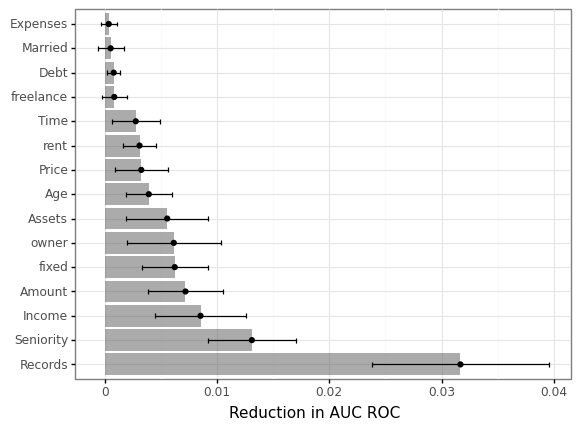

<ggplot: (8772279709594)>

In [39]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

## Part b

## Partial Dependency Plots

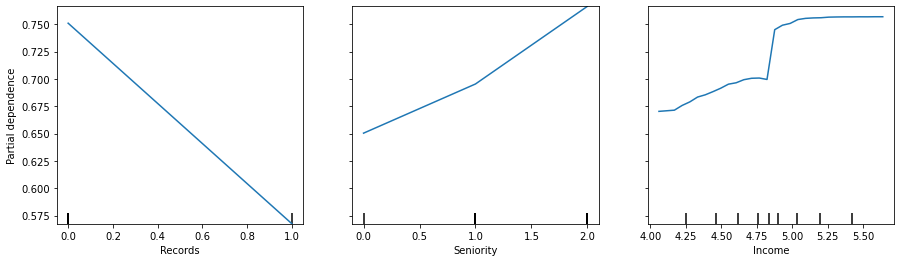

In [40]:
# Target specific features
features = ['Records','Seniority','Income']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=3,
    n_jobs=4, grid_resolution=30,ax=ax
)
# display.figure_.set_figwidth(15)
# display.figure_.set_figheight(4)



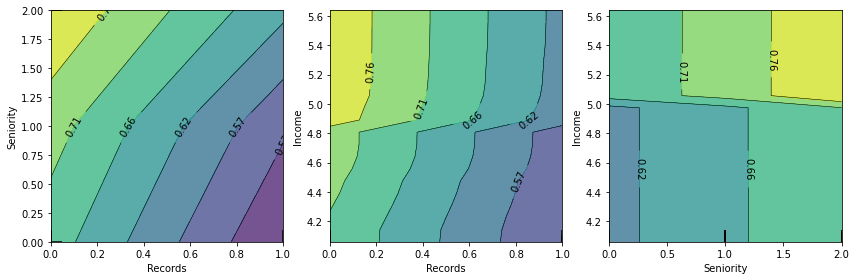

In [41]:
#Interaction Partial Dependency Plots (2D)

# Feed in the ineraction as a nested list
interacted_features = [['Records','Seniority'],['Records','Income'],['Seniority','Income']] 

# Then plot
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X, interacted_features,
    n_cols=3,n_jobs=4, grid_resolution=20,ax=ax
)
fig.tight_layout()

The partial dependence plot shows us that the relationships the model has learned. We see that the relationship between records and status is linear (i.e for people with records, status is always worse). For seniority, the relationship is non-linear (i.e seniority has a greater positive impact on status at higher levels of seniority (more than 1). Similarly, the relationship between income and status is non-linear (income matters most for median values of income). Further, we see that the some of the variables interact together (for example, the relationship between income and status depends on seniority). 

## Part c

## ICE Plots

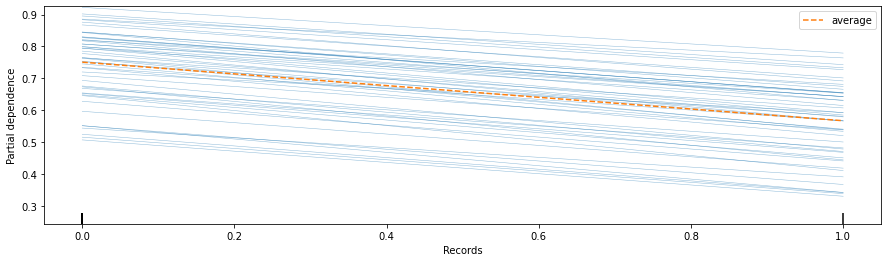

In [42]:
## ICE Plots

features = ['Records']
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    rf_mod,
    train_X,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.5, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)


The ICE plot shows our predictions change for people who do or do not have records. We see that all of the lines follow the same pattern, so there are no obvious interactions. Thus, the relationship between records and status in the partial dependency plot seems to be consistent across observations.

In [43]:
#!pip install scikit-learn --upgrade

## Question 7

One hypothesis I drew from my insights is that income matters for credit status, but not for very low or high levels of income (just for middle levels of income). A potential next step to test this would be to build a linear model with a quadratic variable of income (i.e income squared) to gain better insight into this relationship. 